In [ ]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'branch_1'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.UNet import unet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models.config import *

try:
  executing_on_colab
except NameError:
  executing_on_colab = False

In [3]:
# local configuration
if executing_on_colab is False:
  weights_path = 'models/weights/'
  dataset_path = ROOT_DIR + 'headsegmentation_dataset_ccncsa/'

In [4]:
# defining transforms
tH, tW = 256, 256
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # from ImageNet
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(mean, std)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name='training.xml')
X_train, X_test, Y_train, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

In [5]:
# training hyperparameters
device = 'cuda' if executing_on_colab is True else 'cpu'
batch_size = 32
n_epochs = 50

# model, loss, score function
model_name = 'unet_ccncsa'
model = unet.UNet(out_channels=n_classes)
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_summary = torchsummary.summary(model, input_data=(batch_size, 3, tH, tW), batch_dim=None, verbose=0)
print(model_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [32, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [32, 32, 256, 256]        864
|    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
|    └─ReLU: 2-3                         [32, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [32, 32, 256, 256]        9,216
|    └─BatchNorm2d: 2-5                  [32, 32, 256, 256]        64
|    └─ReLU: 2-6                         [32, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [32, 32, 128, 128]        --
├─Sequential: 1-3                        [32, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [32, 64, 128, 128]        18,432
|    └─BatchNorm2d: 2-8                  [32, 64, 128, 128]        128
|    └─ReLU: 2-9                         [32, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [32, 64, 128, 128]        36,864
| 

In [6]:
# training
results = training_and_testing.train_model(
    device, model, test_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, lr_scheduler=None, evaluate=True, verbose=True)

Device: cuda.
--- Epoch 1/50 ---
average_train_loss: 0.8368944395547626, average_train_score: 0.3400396704673767
average_val_loss: 0.7059953883290291, average_val_score: 0.35246741771698
--- Epoch 2/50 ---
average_train_loss: 0.6856347110079622, average_train_score: 0.35875800251960754
average_val_loss: 0.6828089691698551, average_val_score: 0.35576558113098145
--- Epoch 3/50 ---
average_train_loss: 0.6472966246221258, average_train_score: 0.3710712492465973
average_val_loss: 0.6250878684222698, average_val_score: 0.37511059641838074
--- Epoch 4/50 ---
average_train_loss: 0.6208572271226467, average_train_score: 0.3797146677970886
average_val_loss: 0.6150129400193691, average_val_score: 0.3717288672924042
--- Epoch 5/50 ---
average_train_loss: 0.599005549460992, average_train_score: 0.3838268518447876
average_val_loss: 0.5632658135145903, average_val_score: 0.3849203586578369
--- Epoch 6/50 ---
average_train_loss: 0.555157794349495, average_train_score: 0.38873952627182007
average_val_

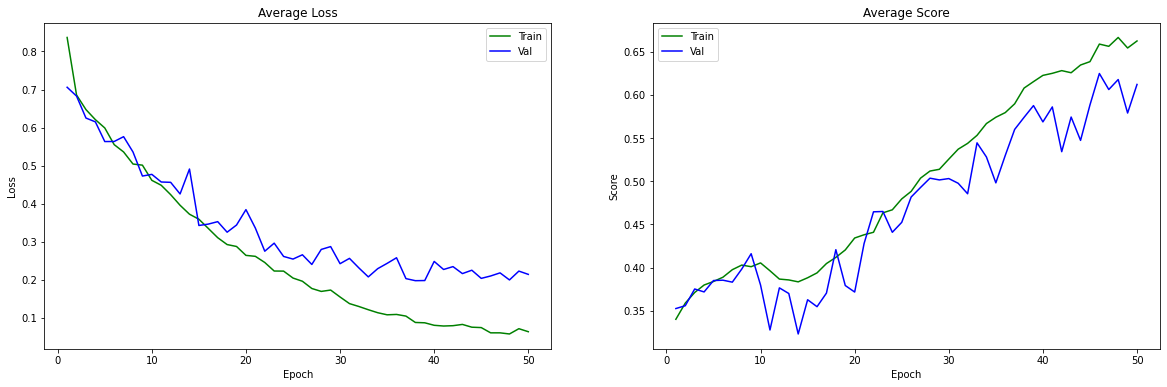

In [7]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [ ]:
# resetting model, optimizer, learning rate scheduler
final_model = unet.UNet(out_channels=n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = n_epochs // 2
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)
    
# saving final model's weights
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')
if executing_on_colab is True:
  torch.save(final_model.state_dict(), weights_path_drive + model_name + '.pth')

In [ ]:
# loading pretrained final model
try:
    final_model
except:
    final_model = unet.UNet(out_channels=n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = { label: score for label, score in list(zip(label_names, batch_IoU.tolist())) }
batch_mIoU = batch_IoU.mean().item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')

In [ ]:
# === plotting some examples from test dataset ===

n_examples = 5
random_images = torch.zeros((n_examples, 3, tH, tW))
random_targets = torch.zeros((n_examples, n_classes, tH, tW))

for i in range(n_examples):
    random_idx = torch.randint(high=len(test_dataset), size=(1,))
    random_image, random_target = test_dataset[random_idx]
    random_images[i] = random_image
    random_targets[i] = random_target

with torch.no_grad():
    final_model.eval()
    random_images = random_images.to(device)
    random_output = final_model(random_images)[0]

channels_max, _ = torch.max(random_output, axis=1)
random_predictions = (random_output == channels_max.unsqueeze(axis=1)).to('cpu')

for i in range(n_examples):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_targets[i], segmentation_labels.labels)))
    plt.subplot(1, 2, 2)
    plt.title('Prediction')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_predictions[i], segmentation_labels.labels)))